# Autoencoder Anomoly Detection

In [26]:
%pip install tensorflow
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## Set Project Paths

Define project-related paths for data input and model output. Using Path.cwd().parents[0] ensures the code remains flexible and adaptable to different environments.

In [27]:
# Paths
project_root = Path.cwd().parents[0]  
data_dir = project_root / "data" / "processed"
model_dir = project_root / "models" / "trained_model"
model_dir.mkdir(parents=True, exist_ok=True)


### Load Processed Dataset

Load the preprocessed feature set X_processed.csv and labels y_processed.csv. 

In [28]:
# Load original (unbalanced) dataset
X = pd.read_csv(data_dir / "X_processed.csv")
y = pd.read_csv(data_dir / "y_processed.csv").squeeze()

## Filter Legitimate Transactions

Since the autoencoder is an unsupervised model used for anomaly detection, we train it only on non-fraudulent transactions where y == 0. This way, it learns the "normal" behavior of the system.


In [29]:
# Keep only legitimate transactions for training 
X_normal = X[y == 0].copy()

## Normalize the Features

To improve model training and convergence, all features are scaled to a 0–1 range using MinMaxScaler. The fitted scaler is saved using joblib so it can apply the same transformation to new data during inference.

In [30]:
# Normalize the features 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_normal)
joblib.dump(scaler, model_dir / "autoencoder_scaler.pkl")

['c:\\Users\\danar\\OneDrive - The University of the West Indies, St. Augustine\\UWI\\Year 3\\Semester 2\\Big Data\\fraud-detection\\models\\trained_model\\autoencoder_scaler.pkl']

## Define Autoencoder Architecture

To create a symmetrical autoencoder using the Keras functional API, ensure that the input layer matches the feature dimension, it includes two encoding layers to reduce the data to a compressed representation, along with two decoding layers to reconstruct the original input. Then use ReLU activations in the hidden layers and a sigmoid activation in the output to match the 0–1 normalized data range. The model would then be compiled using the Adam optimizer and Mean Squared Error loss.


In [31]:
# Define autoencoder architecture 
input_dim = X_scaled.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

## Split Data for Validation

The scaled data is split into training and validation sets using an 80/20 ratio. This allows for the model's performance on unseen data during training to be monitored in order to further help prevent overfitting.

In [32]:
# Split data for validation 
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

## Train Autoencoder Model

The autoencoder is trained to reconstruct its input. Early stopping monitors the validation loss and stops training if the model stops improving for 5 consecutive epochs. This prevents overfitting and saves the best model weights automatically.


In [33]:
# Train autoencoder 
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, X_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0154 - val_loss: 0.0015
Epoch 2/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0013 - val_loss: 9.6976e-04
Epoch 3/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 8.9472e-04 - val_loss: 7.5266e-04
Epoch 4/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.1084e-04 - val_loss: 6.3212e-04
Epoch 5/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.0816e-04 - val_loss: 5.5307e-04
Epoch 6/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.3469e-04 - val_loss: 4.9694e-04
Epoch 7/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.7621e-04 - val_loss: 4.5031e-04
Epoch 8/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.4136e-04 - val_loss: 4.2304e-04
Epoch 9/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.1811e-04 - val_loss: 4.0427e-04
Epoch 10/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.9649e-04 - val_loss: 3.8601e-04
Epoch 11/100
1781/1781 ━━━━━━━━━━━━━━━━━━

## Save Trained Model and Scaler

In [34]:
# Save model and scaler 
autoencoder.save(model_dir / "autoencoder_model.keras")

## Set Reconstruction Error Threshold

After training the autoencoder, how well it can reconstruct the validation data was evaluated, which contains only legitimate or non-fraudulent transactions. To do this, the Mean Squared Error (MSE) was computed between the original input and its reconstructed output for each sample in the validation set.

Legitimate transactions refers to the type the autoencoder was trained on which should have low reconstruction error, since the model has learned their normal patterns. Anomalous transactions refers to fraud which differ from the normal patterns and result in a high reconstruction error, because the model struggles to accurately reconstruct something it hasn't seen before.

Instead of setting an arbitrary reconstruction error cutoff, the 95th percentile was calculated of all MSE scores in the validation set. This means that 95% of the validation samples had reconstruction errors below this value and 5% of legitimate samples had reconstruction errors above this threshold. This can possibly be due to slight natural variations or noise.

By using this value as a threshold, any future sample with a reconstruction error above 0.000856 is assumed to be anomalous or potentially fraudulent. This helps catch outliers while maintaining a relatively low false-positive rate.

In [35]:
# Set threshold based on validation reconstruction error 
X_val_pred = autoencoder.predict(X_val)
mse = np.mean(np.square(X_val - X_val_pred), axis=1)
threshold = np.percentile(mse, 95)
joblib.dump(threshold, model_dir / "autoencoder_threshold.pkl")
print(f"Threshold (95th percentile): {threshold:.6f}")

3562/3562 ━━━━━━━━━━━━━━━━━━━━ 3s 802us/step
Threshold (95th percentile): 0.000856


## Visualize Training and Validation Loss

Plot the training and validation loss curves to visualize how the model's performance evolves across epochs. This helps in assessing model learning behavior, spotting overfitting, and choosing optimal stopping points.

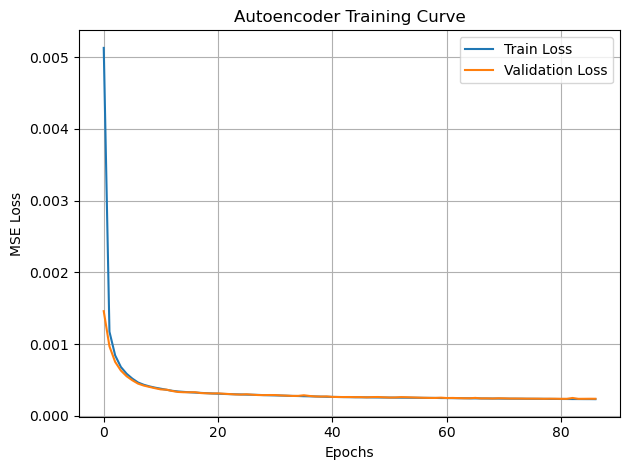

In [36]:
# Plot training and validation loss 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(model_dir / "autoencoder_loss_curve.png")
plt.show()

## Visualization Insights

The graph above shows the Mean Squared Error (MSE) loss over 87 epochs for both training and validation datasets The x axis represents the number of training iterations, ranging from 0 to 100 and the y axis (MSE Loss) represents the loss value, ranging from 0 to 0.005. It should be noted that lower values indicate better performance.

The blue curve representing train loss, shows the loss on the training dataset. It starts high and decreases sharply, flattening out as training progresses. The orange curve representing validation loss shows the loss on the validation dataset. It follows a similar pattern to the training loss, indicating that the model is learning effectively and generalizing well.

### Key Insights

Both curves show a sharp decrease initially, indicating that the model is learning quickly. The curves flatten out towards the end, suggesting that the model's performance is stabilizing and it is not overfitting. This visualization therefore helps assess how well the autoencoder is learning to reconstruct the input data and whether it is generalizing effectively to unseen data.